In [1]:
import rpy2
import scipy
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
import scrublet as scr
import decoupler as dc
from scipy import sparse
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from typing import Optional, Union
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.4.0
defusedxml                  0.7.1
de

# **hdWGCNA in single-cell data**

Here we use `hdWGCNA` to perform co-expression network analysis on single-cell data. 

`hdWGCNA` is an R package for performing `weighted gene co-expression network analysis (WGCNA)` in high dimensional transcriptomics data such as single-cell RNA-seq or spatial transcriptomics. hdWGCNA is highly modular and can construct co-expression networks across multi-scale cellular and spatial hierarchies. hdWGNCA identifies robust modules of inerconnected genes, and provides context for these modules through various biological knowledge sources. hdWGCNA requires data formatted as Seurat objects, one of the most ubiquitous formats for single-cell data. 

`Note: hdWGCNA is under active development, so you may run into errors and small typos. We welcome users to write GitHub issues to report bugs, ask for help, and to request potential enhancements.`

Explore the full capabilites of hWGNA in the following publications:

- [**Morabito et al. bioRxiv 2022**](https://www.biorxiv.org/content/10.1101/2022.09.22.509094v1)
- [**Morabito & Miyoshi et al. Nature Genetics 2021**](https://www.nature.com/articles/s41588-021-00894-z)


Here, apply hdWGCNA to the processed single-nucleus RNA-seq (snRNA-seq) datasets. These dataset have already been fully processed using a standard single-cell transcritpomics analysis pipelines (please see the following notebooks, `preprocessing_data_integration`, `preprocessing_quality_control`, `preprocessing_cluster_annotation`). 


If you would like to apply this notebook to your own dataset, you first need to satisfy the following prerequisites:

A single-cell or single-nucleus transcriptomics dataset in Seurat format.
Normalize the gene expression matrix NormalizeData.
Identify highly variable genes VariableFeatures.
Scale the normalized expression data ScaleData
Perform dimensionality reduction RunPCA and batch correction if needed RunHarmony.
Non-linear dimensionality reduction RunUMAP for visualizations.
Group cells into clusters (FindNeighbors and FindClusters).
An example of running the prerequisite data processing steps can be found in the Seurat Guided Clustering Tutorial.


In [4]:
%%R
suppressPackageStartupMessages({
    library(WGCNA)
    library(Matrix)
    library(viridis)
    library(harmony)
    library(ggpubr)
    library(tictoc)
    library(RColorBrewer)
    library(Hmisc)
    library(corrplot)
    library(grid)
    library(gridExtra)
    library(igraph)
    library(ggrepel)


    # single-cell analysis package
    library(Seurat)

    # plotting and data science packages
    library(tidyverse)
    library(cowplot)
    library(patchwork)

    # co-expression network analysis packages:
    library(WGCNA)
    library(hdWGCNA)

    # gene enrichment packages
    library(enrichR)
    library(GeneOverlap)


    library(GSEABase)
    library(GSVA) 
# needs to be run every time you start R and want to use %>%
})

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
# enableWGCNAThreads(nThreads = 4)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## **Prepare data**

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
save_prefix = 'leng_etc'

adata_annot = sc.read_h5ad(f'../data/processed/{save_prefix}/{save_prefix}_mapped_anndata.h5ad')
adata_annot.obs_names_make_unique()
adata_annot.var_names_make_unique()
adata_annot.X = adata_annot.layers['counts'].copy()
del adata_annot.obsm, adata_annot.layers, adata_annot.varm, adata_annot.uns, adata_annot.obsp


In [6]:
map_meta = True
deg_method =  'DESeq2-Wald'
test_names = ['late_vs_early', 'early_vs_no', 'late_vs_no', 'ad_vs_no']
filter_genes = "TRUE"
subject_id = 'PatientID'                # for leng this is `PatientID` for mathys is 'Subject', and 'individualID' for allen
gene_celltype_threshold = 0.05          # determines number of cells the gene must be expressed in 
covariates = ['None']                   # list of covariates to be accounted for in regression.
gene_selection = 'custom'               # specifies the gene selection method when setting up seurat object for WGCNA. The th
celltypes = ["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"] #["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"]
metadata = f'../data/raw/{save_prefix}/{save_prefix}_metadata.csv' 
meta = pd.read_csv(metadata, encoding_errors='ignore')

gene_selection = 'custom'   # specifies the gene selection method when setting up seurat object for WGCNA. The th
                            # Posible values are "custom", "fraction", "variable"
                            # If custom, a list of genes must be passed.

In [7]:
# map the pathology group to teh subject id in .obs

adata_annot.obs['pathology.group'] = adata_annot.obs[subject_id].map(dict(zip(meta[subject_id].astype(str), meta['pathology.group'])))

In [8]:
%%R -i adata_annot -i subject_id -i gene_celltype_threshold -i celltypes -i test_names -i save_prefix -i gene_selection

print(adata_annot)
print('loaded data into memory for recursive use')

class: SingleCellExperiment 
dim: 16585 41432 
metadata(0):
assays(1): X
rownames(16585): SAMD11 NOC2L ... S100B PRMT2
rowData names(12): mt n_cells_by_counts ... mean std
colnames(41432): EC2_AAACCTGAGGATGCGT EC2_AAACCTGAGTCAATAG ...
  EC10_TTTGTCATCTATCGCC EC10_TTTGTCATCTCTGCTG
colData names(24): SampleID PatientID ... predictions pathology.group
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
[1] "loaded data into memory for recursive use"


In [9]:
del adata_annot

## **Set up Seurat object for WGCNA**

Before running hdWGCNA, we first have to set up the Seurat object. Most of the information computed by hdWGCNA is stored in the Seurat object’s `@misc slot`. 

A single Seurat object can hold multiple hdWGCNA experiments, for example representing different cell types in the same single-cell dataset. Notably, since we consider hdWGCNA to be a downstream data analysis step, we do not need to subset the Seurat object after `SetupForWGCNA` has been run.

Here we will set up the Seurat object using the `SetupForWGCNA` function, specifying the name of the hdWGNCA experiment. This function also selects the genes that will be used for WGCNA. We can aslo select genes using three different approaches using the gene_select parameter:


- `variable`: use the genes stored in the Seurat object’s `VariableFeatures`.

- `fraction`: use genes that are expressed in a certain fraction of cells for in the whole dataset or in each group of cells, specified by group.by.

- `custom`: use genes that are specified in a custom list.

For our specific case, we will either select genes that are expressed in at least 5% of cells within each cell type or specify a list of custom genes. Additionally, we will rename our hdWGCNA experiment to enhance clarity.

Here, the `gene_selection` parameter is set to `custom`, we employ the genes present in all the overlapping pathways in a cell type-specific and study-specific manner.

To accomplish this, we load the list of overlapping pathways that was previously saved in `../results/{test_name}/{test_name}_pathway_overlap.csv` from the `pathway_meta_analysis.ipynb` notebook. Additionally, we load the genes from the `.gmt` file saved in `../results/gsva/{study}/{cur_celltype}/gs.gmt` from the `pathway_analysis.ipynb` notebook.

##### **Overlapping Pathways**

Obtain list of overlapping pathways

In [10]:
# get list of overlapping pathways and save to R                        
overlap_paths = {}

for test_name in test_names:
    overlap_paths[test_name] = pd.read_csv(f'../results/{test_name}/{test_name}_pathway_overlap.csv')

try:
    list_of_overlapping_paths = robjects.ListVector({test_name: robjects.vectors.StrVector(overlap_paths[test_name].pathway.to_list()) for test_name in test_names})
except AttributeError:
    temp_tests = []
    for test_name in test_names:
        if len(overlap_paths.pathway)>0:
            temp_tests.append(test_name)
        else:
            print(f"AttributeError occurred for test_name: {test_name}")
    list_of_overlapping_paths = robjects.ListVector({test_name: robjects.vectors.StrVector(overlap_paths[test_name].pathway.to_list()) for test_name in temp_tests})


Obtain the genesets in the overlapping pathways

In [11]:
%%R -o geneSets -i list_of_overlapping_paths

# iterate over celltypes and obtain 
geneSets <- list()
for(test_name in test_names){

  geneSets[[test_name]] <- list()
  for (cur_celltype in celltypes){
    # get gene sets
    geneSets[[test_name]][[cur_celltype]] <- getGmt(file.path('../results/gsva/', save_prefix, '/', cur_celltype, 'gs.gmt'))
    geneSets[[test_name]][[cur_celltype]] <- geneIds(geneSets[[test_name]][[cur_celltype]])

    # Check if test_name exists in list_of_overlapping_paths
    if (test_name %in% names(list_of_overlapping_paths)) {
      geneSets[[test_name]][[cur_celltype]] <-  geneSets[[test_name]][[cur_celltype]][names(geneSets[[test_name]][[cur_celltype]]) %in% list_of_overlapping_paths[[test_name]]]
      } else {
      geneSets[[test_name]][[cur_celltype]] <- character(0)  # Set an empty vector if no scores exist
    }
    geneSets[[test_name]][[cur_celltype]] <- unique(unlist(geneSets[[test_name]][[cur_celltype]], recursive = FALSE))

    print(length(geneSets[[test_name]][[cur_celltype]]))

  }
}

[1] 455
[1] 2178
[1] 3023
[1] 3222


In [12]:
# convert nested list of geneSets object into Rpy2 object 

geneSets =  robjects.ListVector(
                        {
                            test_name: robjects.ListVector(
                                    {cell_type: geneSets[test_name][cell_type]
                                                 
                                    for cell_type in celltypes
                                    }
                                )
                            for test_name in test_names
                        }

                        )

In [13]:
%%R -o seurat_obj -i geneSets

seurat_obj <- as.Seurat(adata_annot, counts = "X", data = "X")

print(seurat_obj)

# Perform dimensionality reduction and plot

seurat_obj <- FindVariableFeatures(seurat_obj)
seurat_obj <- ScaleData(seurat_obj)
seurat_obj <- RunPCA(seurat_obj)
seurat_obj <- RunHarmony(seurat_obj, group.by.vars = subject_id)
seurat_obj <- RunUMAP(seurat_obj, reduction='harmony', n.neighbors=15, dims=1:30, min.dist=0.1)

p <- DimPlot(seurat_obj, group.by = "cell_type", label = TRUE) +
     umap_theme() + ggtitle("leng") + NoLegend()

# Save plot to PDF
pdf(file = paste0("../results/hdWGCNA/UMAP/", save_prefix, "_integrated_umap.pdf"), width = 4, height = 4, useDingbats = FALSE)
print(p)
dev.off()

# create a hdWGCNA experiment for each celltype
seurat_dat <- seurat_obj
seurat_obj <- list()


for (cur_cell_type in celltypes){

  seurat_obj[[cur_cell_type]] <- subset(seurat_dat, cell_type == cur_cell_type)

  print(paste0('Creating hdWGNA Experiment for ', toupper(cur_cell_type)))

  if (gene_selection == 'custom') {
    seurat_obj[[cur_cell_type]] <- SetupForWGCNA(
      seurat_obj[[cur_cell_type]],
      gene_select = "custom",                                            # the gene selection approach
      gene_list = as.vector(geneSets[['ad_vs_no']][[cur_cell_type]]),    # list of genes to be included
      group.by = 'cell_type',                                            # grouping parameter
      wgcna_name = toupper(substr(cur_cell_type, 1, 3))                  # the name of the hdWGCNA experiment
    )
  } else {
    seurat_obj[[cur_cell_type]] <- SetupForWGCNA(
      seurat_obj[[cur_cell_type]],
      gene_select = "fraction",                               # the gene selection approach
      fraction = gene_celltype_threshold,                     # fraction of cells for gene inclusion
      group.by = 'cell_type',                                 # grouping parameter
      wgcna_name = toupper(substr(cur_cell_type, 1, 3))       # the name of the hdWGCNA experiment
    )
  }

  print(seurat_obj[[cur_cell_type]])
  print(paste0(length(GetWGCNAGenes(seurat_obj[[cur_cell_type]])), " WGCNA Genes"))

}

rm(seurat_dat)
rm(adata_annot)

An object of class Seurat 
16585 features across 41432 samples within 1 assay 
Active assay: originalexp (16585 features, 0 variable features)
[1] "Creating hdWGNA Experiment for EXCITATORY"
An object of class Seurat 
16585 features across 10449 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap
[1] "3222 WGCNA Genes"


Send list to R interface

In [14]:
# convert nested list of Seurat object into Rpy2 object 

seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

## **Construct metacells**

After setting up our Seurat object, the first step in running the hdWGCNA pipeine in hdWGCNA is to construct metacells from the single-cell dataset. 

Briefly, `metacells are aggregates of small groups of similar cells originating from the same biological sample of origin.` The k-Nearest Neighbors (KNN) algorithm is used to identify groups of similar cells to aggregate, and then the average or summed expression of these cells is computed, thus yielding a metacell gene expression matrix. `The sparsity of the metacell expression matrix is considerably reduced` when compared to the original expression matrix, and therefore it is preferable to use. We were originally motivated to use metacells in place of the original single cells because correlation network approaches such as WGCNA are sensitive to data sparsity. Furthermore, single-cell epigenomic approaches, such as Cicero, employ a similar metacell aggregation approach prior to constructing co-accessibility networks.

hdWGCNA includes a function MetacellsByGroups to construct metacell expression matrices given a single-cell dataset. This function constructs a new Seurat object for the metacell dataset which is stored internally in the hdWGCNA experiment. 

The `group.by` parameter determines which groups metacells will be constructed in. 

`We only want to construct metacells from cells that came from the same biological sample of origin, so it is critical to pass that information to hdWGCNA via the group.by parameter.` 

Additionally, we usually construct metacells for each cell type separately. `Thus, in this example, we are grouping by Sample and cell_type to achieve the desired result.`

The number of cells to be aggregated k should be tuned based on the size of the input dataset, in general a lower number for k can be used for small datasets. `Generally use k values between 20 and 75 for 40,039 cells`, ranging from 890 to 8,188 in each biological sample, and here we used k=25. The amount of allowable overlap between metacells can be tuned using the max_shared argument.

Note: The metacell aggregation approach does not yield good results for extremely underrepresented cell types. For example, the brain vascular cells (pericytes and endothelial cells), thus we have excluded them from this analysis. 

`MetacellsByGroups `has a parameter min_cells to exclude groups that are smaller than a specified number of cells. Errors are likely to arise if the selected value for min_cells is too low.

`Here we construct metacells and normalize in each hdWGCNA experiment`

The resulting expression matrix is obtained using the following code:

In [15]:
%%R -i seurat_obj -o seurat_obj

# construct metacells in each group for each wgnca experiment

for (cell_type in celltypes){

  print(paste0('Constructing MetaCells in hdWGCNA Experiment for ', toupper(cell_type)))
  
  seurat_obj[[cell_type]] <- MetacellsByGroups(
      
    seurat_obj = seurat_obj[[cell_type]],
    group.by = c("cell_type", subject_id), # specify the columns in seurat_obj@meta.data to group by
    reduction = 'harmony',  # select the dimensionality reduction to perform KNN on
    k = 25, # nearest-neighbors parameter
    max_shared = 10, # maximum number of shared cells between two metacells
    ident.group = 'cell_type', # set the Idents of the metacell seurat object
    wgcna_name = toupper(substr(cell_type, 1, 3)),        # the name of the hdWGCNA experiment
    )

    # normalize metacell expression matrix:
  seurat_obj[[cell_type]] <- NormalizeMetacells(seurat_obj[[cell_type]],  wgcna_name = toupper(substr(cell_type, 1, 3)))
}


NameError: name 'seurat_obj' is not defined.

In [16]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

## **Process the Metacell Seurat Object**

Since we store the Metacell expression information as its own Seurat object, we can run Seurat functions on the metacell data. We can get the metacell object from the hdWGCNA experiment using `GetMetacellObject.`

In [17]:
# %%R -i seurat_obj -o metacell_obj

# metacell_obj <- list()
# for (cell_type in celltypes){
#     print(paste0('Obtaining MetaCells in hdWGCNA Experiment for ', toupper(cell_type)))
#     metacell_obj[[cell_type]] <- GetMetacellObject(seurat_obj[[cell_type]] , 
#                                         wgcna_name = toupper(substr(cell_type, 1, 3))       # the name of the hdWGCNA experiment
#                                      )
#     print(metacell_obj[[cell_type]])
# }

**`OPTIONAL`**: Here we use wrapper functions to process the metacell object and visualize one of the aggregated expression profiles in two dimensions with UMAP.

In [1]:
# %%R -i seurat_obj -o seurat_obj


# for (cell_type in celltypes){

#     print(paste0('Processing MetaCells in hdWGCNA Experiment for ', toupper(cell_type)))
    
#     seurat_obj[[cell_type]]  <- NormalizeMetacells(seurat_obj[[cell_type]])
#     seurat_obj[[cell_type]]  <- ScaleMetacells(seurat_obj[[cell_type]] , features=VariableFeatures(seurat_obj[[cell_type]]))
#     seurat_obj[[cell_type]]  <- RunPCAMetacells(seurat_obj[[cell_type]] , features=VariableFeatures(seurat_obj[[cell_type]]))
#     seurat_obj[[cell_type]]  <- RunHarmonyMetacells(seurat_obj[[cell_type]] , group.by.vars=subject_id)
#     seurat_obj[[cell_type]]  <- RunUMAPMetacells(seurat_obj[[cell_type]] , reduction='harmony', dims=1:15)


#     p1 <- DimPlotMetacells(seurat_obj[[cell_type]] , group.by='cell_type') + umap_theme() + ggtitle("Cell Type")
#     p2 <- DimPlotMetacells(seurat_obj[[cell_type]] , group.by=subject_id) + umap_theme() + ggtitle(subject_id)

#     p1 | p2

# }

In [2]:
# # convert nested list of Seurat object into Rpy2 object 
# seurat_obj =  robjects.ListVector(
#                         {
#                             cell_type: seurat_obj[cell_type]
                     
#                             for cell_type in celltypes
#                         }
#                     )

## **Co-expression network analysis**

### **Set up the expression matrix**

Here we specify the expression matrix that we will use for network analysis. We only include a single cell-type of interest per run/simulation, so we have to subset our expression data prior to constructing the network. hdWGCNA includes the `SetDatExpr` function to store the transposed expression matrix for a given group of cells that will be used for downstream network analysis.

The metacell expression matrix is used by default `(use_metacells=TRUE)`, but hdWGCNA does allow for the single-cell expression matrix to be used if desired.. This function allows the user to specify which slot to take the expression matrix from, for example if the user wanted to apply SCTransform normalization instead of NormalizeData.

In [20]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in celltypes){

    print(paste0('Setting up expression matrix in hdWGCNA Experiment for ', toupper(cell_type)))

    seurat_obj[[cell_type]] <- SetDatExpr(
      seurat_obj[[cell_type]],
      group_name = cell_type, # the name of the group of interest in the group.by column
      group.by = 'cell_type', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
      assay = 'originalexp', # using RNA assay
      slot = 'data', # using normalized data
      wgcna_name = toupper(substr(cell_type, 1, 3)) # the name of the hdWGCNA experiment
    )
}

[1] "Setting up expression matrix in hdWGCNA Experiment for EXCITATORY"
[1] "Setting up expression matrix in hdWGCNA Experiment for INHIBITORY"
[1] "Setting up expression matrix in hdWGCNA Experiment for ASTROCYTE"
[1] "Setting up expression matrix in hdWGCNA Experiment for MICROGLIA"
[1] "Setting up expression matrix in hdWGCNA Experiment for OLIGODENDROCYTE"
[1] "Setting up expression matrix in hdWGCNA Experiment for OPC"


In [21]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

### **Select soft-power threshold**

Next we will select the “soft power threshold”. This is an extremely important step in the hdWGNCA pipleine (and for vanilla WGCNA). hdWGCNA constructs a gene-gene correlation adjacency matrix to infer co-expression relationships between genes. The correlations are raised to a power to reduce the amount of noise present in the correlation matrix, thereby retaining the strong connections and removing the weak connections. Therefore, it is critical to determine a proper value for the soft power threshold.

We use the function `TestSoftPowers` to perform a parameter sweep for different soft power thresholds. This function helps us to guide our choice in a soft power threshold for constructing the co-expression network by inspecting the resulting network topology for different power values. The co-expression network should have a scale-free topology, therefore the TestSoftPowers function models how closely the co-expression network resembles a scale-free graph at different soft power thresholds. Furthermore, we use the function `PlotSoftPowers` to visualize the results of the parameter sweep.

The following code performs the parameter sweep and outputs a summary figure.

In [22]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/SoftPower/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in celltypes){
  
  print(paste0('Estinmating Soft-Power Threshold in hdWGCNA Experiment for ', toupper(cell_type)))

  # Test different soft powers:
  seurat_obj[[cell_type]] <- TestSoftPowers(
    seurat_obj[[cell_type]],
    networkType = 'signed', # you can also use "unsigned" or "signed hybrid"
    setDatExpr = TRUE,
    group.by = 'cell_type',
    group_name = cell_type,
  )

  # plot the results:
  plot_list <- PlotSoftPowers(seurat_obj[[cell_type]], 
                              # wgcna_name = toupper(substr(cell_type, 1, 3)) # the name of the hdWGCNA experiment
                              )

  # assemble with patchwork
  pdf(paste0(fig_dir, cell_type, '_SoftPower.pdf'), width=12, height=8)
  print(wrap_plots(plot_list, ncol=2))
  dev.off()
}



[1] "Estinmating Soft-Power Threshold in hdWGCNA Experiment for EXCITATORY"
pickSoftThreshold: will use block size 3222.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3222 of 3222
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.   max.k.
1      1 0.098000  8.000          0.955 1.66e+03  1.66e+03 1810.000
2      2 0.000991  0.369          0.909 8.65e+02  8.59e+02 1030.000
3      3 0.005660 -0.598          0.883 4.56e+02  4.50e+02  601.000
4      4 0.062300 -1.460          0.853 2.43e+02  2.37e+02  355.000
5      5 0.222000 -2.190          0.872 1.31e+02  1.26e+02  215.000
6      6 0.457000 -3.200          0.912 7.14e+01  6.72e+01  139.000
7      7 0.640000 -3.790          0.954 3.94e+01  3.63e+01   91.500
8      8 0.777000 -3.810          0.977 2.20e+01  1.97e+01   62.000
9      9 0.857000 -3.710          0.985 1.25e+01  1.07e+01   42.900
10    10 0.904000 -3.460          0.990 7.17e+00  5.92e+00   30.300
11    12 0.946000 -3.

In [23]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in celltypes
                        }
                    )

The general guidance for WGCNA and hdWGCNA is to `pick the lowest soft power threshold that has a Scale Free Topology Model Fit greater than or equal to 0.8`. Later on, the `ConstructNetwork `will automatically select the soft power threshold if we do not provide one.

The output table from the parameter sweep is stored in the hdWGCNA experiment and can be accessed using the GetPowerTable function for further inspection:

In [24]:
# %%R -i seurat_obj -o seurat_obj

# power_table <- GetPowerTable(seurat_obj)
# head(power_table)

### **Construct co-expression network**

We now have everything that we need to construct our co-expression network. Here we use the hdWGCNA function ConstructNetwork, which calls the WGCNA function blockwiseConsensusModules under the hood. This function has quite a few parameters to play with if for advanced use cases, but we use default parameters that work well with many single-cell datasets. 

The parameters for blockwiseConsensusModules can be passed directly to ConstructNetwork with the same parameter names.

The following code construtcts the co-expression network using the soft power threshold selected above:

In [25]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in celltypes) {
  
  print(paste0('Constructing co-expression network in hdWGCNA Experiment for ', toupper(cell_type)))
  
  tryCatch({
    # construct co-expression network:
    seurat_obj[[cell_type]] <- ConstructNetwork(
      seurat_obj[[cell_type]], 
      soft_power = NULL, # Set to NULL so that the ConstructNetwork function obtains it automatically (Scale Free Topology Model Fit >= 0.8)
      setDatExpr = FALSE,
      overwrite_tom = TRUE,
      tom_name = toupper(substr(cell_type, 1, 3)) # name of the topological overlap matrix written to disk set as the name of the hdWGCNA experiment 
    )
  }, error = function(e) {
    print(paste0('Error encountered while processing ', toupper(cell_type)))
    print(paste0(toupper(cell_type), ' dropped from experiment'))
    # Code to handle the error condition
    seurat_obj <- seurat_obj[names(seurat_obj) != cell_type]
    assign("seurat_obj", seurat_obj, envir = .GlobalEnv) # Update the modified seurat_obj in the global environment

  },  
  message = function(m) {
    print(paste0('Error encountered while processing ', toupper(cell_type)))
    print(paste0(toupper(cell_type), ' dropped from experiment'))
    # Code to handle the error condition
    seurat_obj <- seurat_obj[names(seurat_obj) != cell_type]
    assign("seurat_obj", seurat_obj, envir = .GlobalEnv) # Update the modified seurat_obj in the global environment

  }) 
  
}


print(names(seurat_obj))


[1] "Constructing co-expression network in hdWGCNA Experiment for EXCITATORY"
Soft power not provided. Automatically using the lowest power that meets 0.8 scale-free topology fit. Using soft_power = 9
 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..
[1] "Constructing co-expression network in hdWGCNA Experiment for INHIBITORY"
Soft power not provided. Automatically using the lowest power that meets 0.8 scale-free topology fit. Using soft_power = 6
 Calculating consensus modules and module eigengenes block-wise from all g

In [26]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

hdWGCNA also includes a function PlotDendrogram to visualize the WGCNA dendrogram, a common visualization to show the different co-expression modules resulting from the network analysis. Each leaf on the dendrogram represents a single gene, and the color at the bottom indicates the co-expression module assignment.


`Importantly, the “grey” module consists of genes that were not grouped into any co-expression module. The grey module should be ignored for all downstream analysis and interpretation.`

In [27]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/dendrogram/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

tryCatch({
    for (cell_type in names(seurat_obj)){
        # print(paste0('Constructing co-expression networkd in hdWGCNA Experiment for ', toupper(cell_type)))
        pdf(paste0(fig_dir, cell_type, "_dendro.pdf"), height=2, width=4)
        PlotDendrogram(seurat_obj[[cell_type]], main='hdWGCNA Dendrogram')
        dev.off()
    }
}, error = function(e){
    NULL
})

In [28]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### **`OPTIONAl`: inspect the topoligcal overlap matrix (TOM)**

hdWGCNA represents the co-expression network as a `topoligcal overlap matrix (TOM)`. This is a square matrix of genes by genes, where each value is the topoligcal overlap between the genes. The TOM is written to the disk when running ConstructNetwork, and we can load it into R using the GetTOM function. 

We may wish to inspect the TOM for custom downstream analyses.



In [29]:
# %%R -i seurat_obj -o seurat_obj -o TOM

# TOM <- GetTOM(seurat_obj)

### **Module Eigengenes and Connectivity**

### Compute harmonized module eigengenes

`Module Eigengenes (MEs)` are a commonly used metric to summarize the gene expression profile of an entire co-expression module. Briefly, module eigengenes are computed by performing principal component analysis (PCA) on the subset of the gene expression matrix comprising each module. `The first PC of each of these PCA matrices are the MEs.`

Dimensionality reduction techniques are a very hot topic in single-cell genomics. It is well known that technical artifacts can muddy the analysis of single-cell datasets, and over the years there have been many methods that aim to reduce the effects of these artifacts. Therefore it stands to reason that `MEs would be subject to these technical artifacts as well`, and hdWGCNA seeks to alleviate these effects.

`hdWGCNA includes a function ModuleEigengenes` to compute module eigengenes in single cells. Additionally, we can apply Harmony batch correction to the MEs, yielding harmonized module eigengenes (hMEs).

The following code performs the module eigengene computation `harmonizing by the Sample of origin using the group.by.vars parameter.`

In [30]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){

    print(paste0('Estimating module eigen-genes in hdWGCNA Experiment for ', toupper(cell_type)))
    
    # need to run ScaleData first or else harmony throws an error:
    seurat_obj[[cell_type]] <- ScaleData(seurat_obj[[cell_type]], features=VariableFeatures(seurat_obj[[cell_type]]))

    # compute all MEs in the full single-cell dataset
    seurat_obj[[cell_type]] <- ModuleEigengenes(
    seurat_obj[[cell_type]],
    group.by.vars=subject_id
    )
    print('----------------')

}

[1] "Estimating module eigen-genes in hdWGCNA Experiment for EXCITATORY"
[1] "grey"
[1] "turquoise"
[1] "blue"
[1] "brown"
[1] "yellow"
[1] "green"
[1] "----------------"
[1] "Estimating module eigen-genes in hdWGCNA Experiment for INHIBITORY"
[1] "turquoise"
[1] "blue"
[1] "brown"
[1] "grey"
[1] "green"
[1] "yellow"
[1] "----------------"
[1] "Estimating module eigen-genes in hdWGCNA Experiment for ASTROCYTE"
[1] "brown"
[1] "grey"
[1] "turquoise"
[1] "blue"
[1] "yellow"
[1] "----------------"
[1] "Estimating module eigen-genes in hdWGCNA Experiment for MICROGLIA"
[1] "grey"
[1] "blue"
[1] "turquoise"
[1] "----------------"
[1] "Estimating module eigen-genes in hdWGCNA Experiment for OLIGODENDROCYTE"
[1] "turquoise"
[1] "grey"
[1] "blue"
[1] "brown"
[1] "----------------"


In [31]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

The ME matrices are stored as a matrix where each row is a cell and each column is a module. This matrix can be extracted from the Seurat object using the GetMEs function, which retrieves the hMEs by default.

In [32]:
%%R -i seurat_obj -o seurat_obj -o hMEs -o MEs

hMEs <- list()
MEs <- list()

for (cell_type in names(seurat_obj)){
    print(paste0('Getting harmonized and non-harmonized MEs in hdWGCNA Experiment for ', toupper(cell_type)))
    
    # harmonized module eigengenes:
    hMEs[[cell_type]] <- GetMEs(seurat_obj[[cell_type]])

    # module eigengenes:
    MEs[[cell_type]] <- GetMEs(seurat_obj[[cell_type]], harmonized=FALSE)
}

[1] "Getting harmonized and non-harmonized MEs in hdWGCNA Experiment for EXCITATORY"
[1] "Getting harmonized and non-harmonized MEs in hdWGCNA Experiment for INHIBITORY"
[1] "Getting harmonized and non-harmonized MEs in hdWGCNA Experiment for ASTROCYTE"
[1] "Getting harmonized and non-harmonized MEs in hdWGCNA Experiment for MICROGLIA"
[1] "Getting harmonized and non-harmonized MEs in hdWGCNA Experiment for OLIGODENDROCYTE"


In [33]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### Compute module connectivity

In co-expression network analysis, we often want to focus on the `“hub genes”`,`those which are highly connected within each module.` Therefore we wish to determine the `eigengene-based connectivity, also known as kME`, of each gene. 

hdWGCNA includes the ModuleConnectivity to compute the kME values in the full single-cell dataset, rather than the metacell dataset. This function essentially computes pairwise correlations between genes and module eigengenes. kME can be computed for all cells in the dataset, but we recommend computing kME in the cell type or group that was previously used to run ConstructNetwork.

In [34]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){

  print(paste0('Estimating module connectivity in hdWGCNA Experiment for ', toupper(cell_type)))

  # compute eigengene-based connectivity (kME):
  seurat_obj[[cell_type]] <- ModuleConnectivity(
    seurat_obj[[cell_type]],
    group.by = 'cell_type', 
    group_name = cell_type
  )
  
}

[1] "Estimating module connectivity in hdWGCNA Experiment for EXCITATORY"
[1] "Estimating module connectivity in hdWGCNA Experiment for INHIBITORY"
[1] "Estimating module connectivity in hdWGCNA Experiment for ASTROCYTE"
[1] "Estimating module connectivity in hdWGCNA Experiment for MICROGLIA"
[1] "Estimating module connectivity in hdWGCNA Experiment for OLIGODENDROCYTE"


In [35]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

For convenience, we re-name the hdWGCNA modules to indicate that they are from the Excitatory neuron group.

In [36]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){

  print(paste0('Renaming modules in hdWGCNA Experiment for ', toupper(cell_type)))

  # rename the modules
  seurat_obj[[cell_type]] <- ResetModuleNames(
    seurat_obj[[cell_type]],
    new_name = paste0(toupper(substr(cell_type, 1, 3)), "-M"),
    wgcna_name = toupper(substr(cell_type, 1, 3)) # the name of the hdWGCNA experiment,
  )
}

[1] "Renaming modules in hdWGCNA Experiment for EXCITATORY"
[1] "Renaming modules in hdWGCNA Experiment for INHIBITORY"
[1] "Renaming modules in hdWGCNA Experiment for ASTROCYTE"
[1] "Renaming modules in hdWGCNA Experiment for MICROGLIA"
[1] "Renaming modules in hdWGCNA Experiment for OLIGODENDROCYTE"


In [37]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

We also reset module colors

In [38]:
%%R -i seurat_obj -o seurat_obj 



library(MetBrewer)

for (cell_type in names(seurat_obj)){

  print(paste0('Resetting module colors in hdWGCNA Experiment for ', toupper(cell_type)))


  modules <- GetModules(seurat_obj[[cell_type]])
  mods <- levels(modules$module)
  mod_colors <- dplyr::select(modules, c(module, color)) %>%
    distinct %>% arrange(module) %>% .$color
  n_colors <- length(mod_colors) -1

  new_colors <- paste0(met.brewer("Signac", n=n_colors,))
  new_colors <- sample(new_colors)
  seurat_obj[[cell_type]] <- ResetModuleColors(seurat_obj[[cell_type]], new_colors)

}


[1] "Resetting module colors in hdWGCNA Experiment for EXCITATORY"
[1] "Resetting module colors in hdWGCNA Experiment for INHIBITORY"
[1] "Resetting module colors in hdWGCNA Experiment for ASTROCYTE"
[1] "Resetting module colors in hdWGCNA Experiment for MICROGLIA"
[1] "Resetting module colors in hdWGCNA Experiment for OLIGODENDROCYTE"


In [39]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

We can visualize the genes in each module ranked by kME using the PlotKMEs function.

In [40]:
%%R -i seurat_obj -o seurat_obj

library(conflicted)
conflicts_prefer(dplyr::select)

fig_dir = paste0("../results/hdWGCNA/ModuleConnectivity/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){
    
    print(paste0('Visualize Module Connectivity (kMEs) in hdWGCNA Experiment for ', toupper(cell_type)))

    # plot genes ranked by kME for each module

    p <- PlotKMEs(seurat_obj[[cell_type]], ncol=5)

    pdf(paste0(fig_dir, cell_type, '_KMEs.pdf'), width=12, height=8)
    print(p)
    dev.off()
}

[conflicted] Will prefer dplyr::select over any other package.
[1] "Visualize Module Connectivity (kMEs) in hdWGCNA Experiment for EXCITATORY"
[1] "EXC-M1"
[1] "EXC-M2"
[1] "EXC-M3"
[1] "EXC-M4"
[1] "EXC-M5"
[1] "EXC-M1"
[1] "EXC-M2"
[1] "EXC-M3"
[1] "EXC-M4"
[1] "EXC-M5"
[1] "Visualize Module Connectivity (kMEs) in hdWGCNA Experiment for INHIBITORY"
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "Visualize Module Connectivity (kMEs) in hdWGCNA Experiment for ASTROCYTE"
[1] "AST-M1"
[1] "AST-M2"
[1] "AST-M3"
[1] "AST-M4"
[1] "AST-M1"
[1] "AST-M2"
[1] "AST-M3"
[1] "AST-M4"
[1] "Visualize Module Connectivity (kMEs) in hdWGCNA Experiment for MICROGLIA"
[1] "MIC-M1"
[1] "MIC-M2"
[1] "MIC-M1"
[1] "MIC-M2"
[1] "Visualize Module Connectivity (kMEs) in hdWGCNA Experiment for OLIGODENDROCYTE"
[1] "OLI-M1"
[1] "OLI-M2"
[1] "OLI-M3"
[1] "OLI-M1"
[1] "OLI-M2"
[1] "OLI-M3"


In [41]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### Getting the module assignment table

hdWGCNA allows for easy access of the module assignment table using the GetModules function. 

This table consists of three columns: 

- gene_name stores the gene’s symbol or ID, 
- module stores the gene’s module assignment, and 
- color stores a color mapping for each module, 

which is used in many downstream plotting steps. If ModuleConnectivity has been called on this hdWGCNA experiment, this table will have additional columns for the kME of each module.

In [42]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){
    
    print(paste0('Obtain Module Assignment Table in hdWGCNA Experiment for ', toupper(cell_type)))

    # get the module assignment table:
    modules <- GetModules(seurat_obj[[cell_type]])

    # show the first 6 columns:
    print(head(modules[,1:6]))
}

[1] "Obtain Module Assignment Table in hdWGCNA Experiment for EXCITATORY"
      gene_name module   color  kME_grey kME_EXC-M1 kME_EXC-M2
CPEB3     CPEB3   grey    grey 0.6492523  0.4897692  0.6494233
KHSRP     KHSRP EXC-M1 #d8443c 0.2609406  0.3437743  0.2096697
RC3H1     RC3H1 EXC-M2 #1f6e9c 0.5030887  0.3640596  0.5238987
UPF1       UPF1 EXC-M1 #d8443c 0.2347792  0.3130236  0.1866169
ATF6       ATF6   grey    grey 0.4400187  0.3232882  0.4419469
ATF6B     ATF6B EXC-M2 #1f6e9c 0.4374734  0.3454096  0.4447689
[1] "Obtain Module Assignment Table in hdWGCNA Experiment for INHIBITORY"
       gene_name module   color kME_INH-M1 kME_INH-M2 kME_INH-M3
CPEB3      CPEB3 INH-M1 #f4c40f  0.5657084  0.4437647  0.5294876
KHSRP      KHSRP INH-M2 #fe9b00  0.1339092  0.2421545  0.1585205
RC3H1      RC3H1 INH-M1 #f4c40f  0.3680860  0.2969479  0.3035283
UPF1        UPF1 INH-M2 #fe9b00  0.1266984  0.2417525  0.1462117
PAPSS1    PAPSS1 INH-M3 #1f6e9c  0.2613789  0.2884655  0.2908819
PODXL2    PODXL2 INH-

In [43]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

A table of the top N hub genes sorted by kME can be extracted using the GetHubGenes function.

In [44]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){
    
    print(paste0('Obtain Hub Genes in hdWGCNA Experiment for ', toupper(cell_type)))

    # get hub genes
    hub_df <- GetHubGenes(seurat_obj[[cell_type]], n_hubs = 10)

    print(head(hub_df))
}

[1] "Obtain Hub Genes in hdWGCNA Experiment for EXCITATORY"
  gene_name module       kME
1     YWHAG EXC-M1 0.7194861
2      PRNP EXC-M1 0.7196898
3  HSP90AB1 EXC-M1 0.7216076
4      DNM1 EXC-M1 0.7249080
5     GPM6A EXC-M1 0.7411353
6     CALM1 EXC-M1 0.7498506
[1] "Obtain Hub Genes in hdWGCNA Experiment for INHIBITORY"
  gene_name module       kME
1     AKAP6 INH-M1 0.6087143
2      ERC1 INH-M1 0.6250610
3      ANK3 INH-M1 0.6312587
4      LRP4 INH-M1 0.6412409
5    CLASP2 INH-M1 0.6436941
6      GPHN INH-M1 0.6635628
[1] "Obtain Hub Genes in hdWGCNA Experiment for ASTROCYTE"
  gene_name module       kME
1     PDE4D AST-M1 0.5656367
2    CTNND2 AST-M1 0.5933795
3      GPC5 AST-M1 0.6226433
4     ERBB4 AST-M1 0.6460952
5    ADGRB3 AST-M1 0.6633774
6     NRXN1 AST-M1 0.6692109
[1] "Obtain Hub Genes in hdWGCNA Experiment for MICROGLIA"
  gene_name module       kME
1      GAB2 MIC-M1 0.3462418
2     PRKCA MIC-M1 0.3487579
3    FCHSD2 MIC-M1 0.3521040
4      DPYD MIC-M1 0.3544082
5    KCN

In [45]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

This wraps up the critical analysis steps for hdWGCNA, let's save our output.

In [46]:
%%R -i seurat_obj -o seurat_obj

dat_dir = paste0("../results/hdWGCNA/SeuratObject/", save_prefix, '/')

if (!dir.exists(dat_dir)) {
  dir.create(dat_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){
    
    print(paste0('Saving hdWGCNA object in hdWGCNA Experiment for ', toupper(cell_type)))

    saveRDS(seurat_obj[[cell_type]], file=paste0(dat_dir, cell_type, '_hdWGCNA_object.rds'))

}

[1] "Saving hdWGCNA object in hdWGCNA Experiment for EXCITATORY"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for INHIBITORY"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for ASTROCYTE"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for MICROGLIA"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for OLIGODENDROCYTE"


In [47]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Compute hub gene signature scores**

Gene scoring analysis is a popular method in single-cell transcriptomics for computing a score for the overall signature of a set of genes. Seurat implements their own gene scoring technique using the `AddModuleScore` function, but there are also alternative approaches such as UCell.

hdWGCNA includes the function `ModuleExprScore` to compute gene scores for a give number of genes for each module, using either the Seurat or UCell algorithm. Gene scoring is an alternative way of summarizing the expression of a module from computing the module eigengene.

In [48]:
%%R -i seurat_obj -o seurat_obj

for (cell_type in names(seurat_obj)){
    
  print(paste0('Compute hub gene scores in hdWGCNA Experiment for ', toupper(cell_type)))
    
  # compute gene scoring for the top 25 hub genes by kME for each module
  # with Seurat method
  seurat_obj[[cell_type]] <- ModuleExprScore(
    seurat_obj[[cell_type]],
    n_genes = 25,
    method='Seurat'
  )

  # compute gene scoring for the top 25 hub genes by kME for each module
  # with UCell method
  library(UCell)
  seurat_obj[[cell_type]] <- ModuleExprScore(
    seurat_obj[[cell_type]],
    n_genes = 25,
    method='UCell'
  )
}

[1] "Compute hub gene scores in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "Compute hub gene scores in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
[1] "Compute hub gene scores in hdWGCNA Experiment for ASTROCYTE"
Selecting by kME_AST-M1
Selecting by kME_AST-M2
Selecting by kME_AST-M3
Selecting by kME_AST-M4
Selecting by kME_AST-M1
Selecting by kME_AST-M2
Selecting by kME_AST-M3
Selecting by kME_AST-M4
[1] "Compute hub gene scores in hdWGCNA Experiment for MICROGLIA"
Selecting by kME_MIC-M1
Selecting by kME_MIC-M2
Selecting by k

In [49]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Basic Visualization**

Here we visualize some results using hdWGCNA, and we employ some of Seurat’s built-in plotting tools to visualize our hdWGCNA results.



### **Module Feature Plots**

FeaturePlot is a commonly used Seurat visualization to show a feature of interest directly on the dimensionality reduction. hdWGCNA includes the ModuleFeaturePlot function to consruct FeaturePlots for each co-expression module colored by each module’s uniquely assigned color.

In [50]:
%%R -i seurat_obj -o seurat_obj


fig_dir = paste0("../results/hdWGCNA/FeaturePlots/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){
    
  print(paste0('Module Feature Plots in hdWGCNA Experiment for ', toupper(cell_type)))
     
  # make a featureplot of hMEs for each module
  plot_list <- ModuleFeaturePlot(
    seurat_obj[[cell_type]],
    features='hMEs', # plot the hMEs
    order=TRUE, # order so the points with highest hMEs are on top
    # raster=TRUE, 
    # raster_dpi=400, 
    # alpha=1,
    # restrict_range=FALSE, 
    # raster_scale=0.25,
  )

  plot_list <- lapply(1:length(plot_list), function(x){
    plot_list[[x]] + NoLegend() + theme(plot.title=element_text(face='plain', vjust=0.25), plot.margin=margin(c(0,0,0,0)))
  })

  pdf(paste0(fig_dir, cell_type, "_featureplot_MEs.pdf"), height=10, width=5)
  print(wrap_plots(plot_list, ncol=3))
  dev.off()
}

[1] "Module Feature Plots in hdWGCNA Experiment for EXCITATORY"
[1] "EXC-M1"
[1] "EXC-M2"
[1] "EXC-M3"
[1] "EXC-M4"
[1] "EXC-M5"
[1] "Module Feature Plots in hdWGCNA Experiment for INHIBITORY"
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "Module Feature Plots in hdWGCNA Experiment for ASTROCYTE"
[1] "AST-M1"
[1] "AST-M2"
[1] "AST-M3"
[1] "AST-M4"
[1] "Module Feature Plots in hdWGCNA Experiment for MICROGLIA"
[1] "MIC-M1"
[1] "MIC-M2"
[1] "Module Feature Plots in hdWGCNA Experiment for OLIGODENDROCYTE"
[1] "OLI-M1"
[1] "OLI-M2"
[1] "OLI-M3"


In [51]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

We can also plot the hub gene signature score using the same function:

In [52]:
%%R -i seurat_obj -o seurat_obj


fig_dir = paste0("../results/hdWGCNA/FeaturePlots/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){
    
  print(paste0('Module Feature Plots for HUB GENES in hdWGCNA Experiment for ', toupper(cell_type)))
     
  # make a featureplot of hMEs for each module
  plot_list <- ModuleFeaturePlot(
    seurat_obj[[cell_type]],
    features='scores',  # plot the hub gene scores
    order='shuffle', # order so cells are shuffled
    ucell = TRUE, # depending on Seurat vs UCell for gene scoring
    # raster=TRUE, 
    # raster_dpi=400, 
    # alpha=1,
    # restrict_range=FALSE, 
    # raster_scale=0.25,
  )

  plot_list <- lapply(1:length(plot_list), function(x){
    plot_list[[x]] + NoLegend() + theme(plot.title=element_text(face='plain', vjust=0.25), plot.margin=margin(c(0,0,0,0)))
  })

  pdf(paste0(fig_dir, cell_type, "_featureplot_hubs.pdf"), height=10, width=5)
  print(wrap_plots(plot_list, ncol=3))
  dev.off()
}

[1] "Module Feature Plots for HUB GENES in hdWGCNA Experiment for EXCITATORY"
[1] "EXC-M1"
[1] "EXC-M2"
[1] "EXC-M3"
[1] "EXC-M4"
[1] "EXC-M5"
[1] "Module Feature Plots for HUB GENES in hdWGCNA Experiment for INHIBITORY"
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "Module Feature Plots for HUB GENES in hdWGCNA Experiment for ASTROCYTE"
[1] "AST-M1"
[1] "AST-M2"
[1] "AST-M3"
[1] "AST-M4"
[1] "Module Feature Plots for HUB GENES in hdWGCNA Experiment for MICROGLIA"
[1] "MIC-M1"
[1] "MIC-M2"
[1] "Module Feature Plots for HUB GENES in hdWGCNA Experiment for OLIGODENDROCYTE"
[1] "OLI-M1"
[1] "OLI-M2"
[1] "OLI-M3"


In [53]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### **Module Correlations**

hdWGCNA includes the ModuleCorrelogram function to visualize the correlation between each module based on their hMEs, MEs, or hub gene scores using the R package corrplot.

In [54]:
%%R -i seurat_obj -o seurat_obj


fig_dir = paste0("../results/hdWGCNA/ModuleCorrelations/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

    print(paste0('Module Correlation in hdWGCNA Experiment for ', toupper(cell_type)))
    # plot module correlagram
    pdf(paste0(fig_dir, cell_type, "_correlogram.pdf"), height=10, width=5)
    ModuleCorrelogram(seurat_obj[[cell_type]])
    dev.off()
}

[1] "Module Correlation in hdWGCNA Experiment for EXCITATORY"
[1] "Module Correlation in hdWGCNA Experiment for INHIBITORY"
[1] "Module Correlation in hdWGCNA Experiment for ASTROCYTE"
[1] "Module Correlation in hdWGCNA Experiment for MICROGLIA"
[1] "Module Correlation in hdWGCNA Experiment for OLIGODENDROCYTE"


In [55]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### **Seurat plotting functions**


The base Seurat plotting functions are also great for visualizing hdWGCNA outputs. Here we demonstrate plotting hMEs using DotPlot and VlnPlot. The key to using Seurat’s plotting functions to visualize the hdWGCNA data is to add it into the Seurat object’s @meta.data slot:

In [56]:
%%R -i seurat_obj -o seurat_obj -o mods

mods <- list()

for (cell_type in names(seurat_obj)){

    # get hMEs from seurat object
    MEs <- GetMEs(seurat_obj[[cell_type]], harmonized=TRUE)
    mods[[cell_type]] <- colnames(MEs); 
    mods[[cell_type]] <- mods[[cell_type]][mods[[cell_type]] != 'grey']
    
    
    # add hMEs to Seurat meta-data:
    seurat_obj[[cell_type]]@meta.data <- cbind(seurat_obj[[cell_type]]@meta.data, MEs)
}

In [57]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )


# convert nested list of Seurat object into Rpy2 object 
mods =  robjects.ListVector(
                        {
                            cell_type: mods[cell_type]
                     
                            for cell_type in mods.keys()
                        }
                    )

Now we can easily use Seurat’s DotPlot function:

In [58]:
%%R -i seurat_obj -i mods -o seurat_obj



fig_dir = paste0("../results/hdWGCNA/DotPlot/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){

  print(paste0('DotPlot for average expression of MEs in hdWGCNA Experiment for ', toupper(cell_type)))

  # plot with Seurat's DotPlot function
  p <- DotPlot(seurat_obj[[cell_type]], features=mods[[cell_type]], group.by = 'cell_type')

  # flip the x/y axes, rotate the axis labels, and change color scheme:
  p <- p +
    coord_flip() +
    RotatedAxis() +
    scale_color_gradient2(high='red', mid='grey95', low='blue')

  pdf(paste0(fig_dir, cell_type, "_dotplot.pdf"), height=10, width=5)
  print(p)
  dev.off()

}

[1] "DotPlot for average expression of MEs in hdWGCNA Experiment for EXCITATORY"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
[1] "DotPlot for average expression of MEs in hdWGCNA Experiment for INHIBITORY"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
[1] "DotPlot for average expression of MEs in hdWGCNA Experiment for ASTROCYTE"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
[1] "DotPlot for average expression of MEs in hdWGCNA Experiment for MICROGLIA"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
[1] "DotPlot for average expression of MEs in hdWGCNA Experiment for OLIGODENDROCYTE"
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [59]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )


Here is another example where we use Seurat’s VlnPlot function:

In [60]:
# %%R -i seurat_obj -o seurat_obj


# for (cell_type in names(seurat_obj)){

#   print(paste0('ViolinPlot for average expression of MEs in hdWGCNA Experiment for ', toupper(cell_type)))

#   # Plot INH-M4 hME using Seurat VlnPlot function
#   p <- VlnPlot(
#     seurat_obj,
#     features = as.vector(mods[[cell_type]]),
#     group.by = 'cell_type',
#     pt.size = 0 # don't show actual data points
#   )

#   # add box-and-whisker plots on top:
#   p <- p + geom_boxplot(width=.25, fill='white')

#   # change axis labels and remove legend:
#   p <- p + xlab('') + ylab('hME') + NoLegend()

#   # plot output
#   pdf(paste0("../results/hdWGCNA/ViolinPlot/", save_prefix, '_', cell_type, "_violinplot.pdf"), height=10, width=5)
#   print(p)
#   dev.off()

# }


In [61]:
# # convert nested list of Seurat object into Rpy2 object 
# seurat_obj =  robjects.ListVector(
#                         {
#                             cell_type: seurat_obj[cell_type]
                     
#                             for cell_type in seurat_obj.keys()
#                         }
#                     )


# **Network Visualization**


Here, we visualize the co-expression networks made with hdWGCNA using the following functions:

- `ModuleNetworkPlot`, visualizes a separate network plot for each module, showing the top N genes by kME.
- `HubGeneNetworkPlot`, visualizes the network comprisng all modules with a given number of hub genes per module.
- `ModuleUMAPPlot`, visualizes all of the genes in the co-expression simultaneously using the UMAP dimensionality reduction algorithm.

## **Individual module network plots**


Here we demonstrate using the `ModuleNetworkPlot` function to visualize the network underlying the top 25 hub genes for each module. By default, this function creates a new folder called “ModuleNetworks”, and generates a .pdf figure for each module.



In [62]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0('../results/hdWGCNA/NetworkPlot/', save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('Module network plots in hdWGCNA Experiment for ', toupper(cell_type)))

  # individual module networks
  ModuleNetworkPlot(
    seurat_obj[[cell_type]],
    mods = "all",
    outdir = paste0(fig_dir, cell_type, '_hubNetworks/')
  )
}

[1] "Module network plots in hdWGCNA Experiment for EXCITATORY"
Writing output files to ../results/hdWGCNA/NetworkPlot/leng_etc/Excitatory_hubNetworks/Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "EXC-M1"
[1] "EXC-M2"
[1] "EXC-M3"
[1] "EXC-M4"
[1] "EXC-M5"
[1] "Module network plots in hdWGCNA Experiment for INHIBITORY"
Writing output files to ../results/hdWGCNA/NetworkPlot/leng_etc/Inhibitory_hubNetworks/Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "Module network plots in hdWGCNA Experiment for ASTROCYTE"
Writing output files to ../results/hdWGCNA/NetworkPlot/leng_etc/Astrocyte_hubNetworks/Selecting by kME_AST-M1
Selecting by kME_AST-M2
Selecting by kME_AST-M3
Selecting by kME_AST-M4
[1] "AST-M1"
[1] "AST-M2"
[1] "AST-M3"
[1] "AST-M4"
[1] "Module network plots in hd

In this network, each node represents a gene, and each edge represents the co-expression relationship between two genes in the network. Each of these module network plots are colored based on the color column in the hdWGCNA module assignment table GetModules(seurat_obj). The top 10 hub genes by kME are placed in the center of the plot, while the remaining 15 genes are placed in the outer circle.

Optionally, certain visualization parameters can be changed in this plot:

- `edge.alpha`: determines the opacity of the network edges
- `vertex.size`: determines the size of the nodes
- `vertex.label.cex`: determines the font size of the gene label


In [63]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Combined hub gene network plots**

Here we will make a network plot combining all of the modules together using the `HubGeneNetworkPlot` function. 

This function takes the top n hub genes, and other randomly selected genes, and constructs a joint network using the force-directed graph drawing algorithm. For visual clarity, the number of edges in the network can be downsampled using the edge_prop parameter. In the following example, we visualize the top 3 hub genes and 6 other genes per module.



In [64]:
%%R -i seurat_obj -o seurat_obj



  fig_dir = paste0("../results/hdWGCNA/HubGeneNetworkPlot/", save_prefix, '/')
  if (!dir.exists(fig_dir)) {
    dir.create(fig_dir, recursive=TRUE)
  }


for (cell_type in names(seurat_obj)){

  print(paste0('Hubs Gene Network Plot in hdWGCNA Experiment for ', toupper(cell_type)))

  # hubgene network

  # Save plot to PDF
  pdf(file = paste0(fig_dir,  cell_type, "_allHubGeneNetwork.pdf"), width = 4, height = 4, useDingbats = FALSE)
  HubGeneNetworkPlot(
    seurat_obj[[cell_type]],
    n_hubs = 6,
    n_other=3,
    edge_prop = 0.75,
    mods = 'all',
    sample_edges = TRUE,
    return_graph = FALSE,
    edge.alpha = 0.25,
    vertex.label.cex = 0.25,
    hub.vertex.size = 6,
    other.vertex.size = 2,
    wgcna_name = NULL,

  )
  dev.off()

}

[1] "Hubs Gene Network Plot in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5

  grey EXC-M1 EXC-M2 EXC-M3 EXC-M4 EXC-M5 
     3      9      9      9      9      9 
[1] "#d8443c" "grey90"  "#1f6e9c" "#f4c40f" "#de597c" "#fe9b00"
[1] "here"
[1] 308   4
[1] "Hubs Gene Network Plot in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5

INH-M1 INH-M2 INH-M3   grey INH-M4 INH-M5 
     9      9      9      3      9      9 
[1] "#f4c40f" "grey90"  "#fe9b00" "#1f6e9c" "#d8443c" "#de597c"
[1] "here"
[1] 465   4
[1] "Hubs Gene Network Plot in hdWGCNA Experiment for ASTROCYTE"
Selecting by kME_AST-M1
Selecting by kME_AST-M2
Selecting by kME_AST-M3
Selecting by kME_AST-M4

AST-M1   grey AST-M2 AST-M3 AST-M4 
     9      3      9      9      9 
[1] "#1f6e9c" "grey90"  "#d8443c" "#fe9b00" "#

In [65]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

As in the previous network plot, each node represents a gene and each edge represents a co-expression relationship. In this network, `we color intramodular edges with the module’s color, and intermodular edges gray.` The opacity of edges in this network is scaled by the strength of the co-expression relationship.

## **Applying UMAP to co-expression networks**

We have only visualized a subset of the co-expression network with an emphasis on the hub genes. Here, we use an alternative approach to visualize all genes in the co-expression network simultaneously. UMAP is a suitable method for visualizing high-dimensional data in two dimensions, and here we apply UMAP to embed the hdWGCNA network in a low-dimensional manifold.

hdWGCNA includes the function `RunModuleUMAP to run the UMAP algorithm on the hdWGCNA topological overlap matrix (TOM)`. For the UMAP analysis, we subset the columns in the TOM to only contain the top n hub genes by kME for each module. 

Therefore, the organization of each gene in UMAP space is dependent on that gene’s connectivity with the network’s hub genes. This function leverages the UMAP implementation from the uwot R package, so additional UMAP parameters for the uwot::umap function such as min_dist or spread can be included in RunModuleUMAP.

The following code demonstrates using the RunModuleUMAP function with 10 hub genes per module:

In [66]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in names(seurat_obj)){

  print(paste0('Obtaining Module UMAP in hdWGCNA Experiment for ', toupper(cell_type)))

  seurat_obj[[cell_type]] <- RunModuleUMAP(
    seurat_obj[[cell_type]],
    n_hubs = 5, # number of hub genes to include for the UMAP embedding
    n_neighbors=15, # neighbors parameter for UMAP
    min_dist=0.3, # min distance between points in UMAP space
    spread = 2,
  )
}

[1] "Obtaining Module UMAP in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "Obtaining Module UMAP in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
[1] "Obtaining Module UMAP in hdWGCNA Experiment for ASTROCYTE"
Selecting by kME_AST-M1
Selecting by kME_AST-M2
Selecting by kME_AST-M3
Selecting by kME_AST-M4
[1] "Obtaining Module UMAP in hdWGCNA Experiment for MICROGLIA"
Selecting by kME_MIC-M1
Selecting by kME_MIC-M2
[1] "Obtaining Module UMAP in hdWGCNA Experiment for OLIGODENDROCYTE"
Selecting by kME_OLI-M1
Selecting by kME_OLI-M2
Selecting by kME_OLI-M3


In [67]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

Next we will make a simple visualization of the UMAP for Excitatory cells using ggplot2:

[1] "Store Module UMAP in hdWGCNA Experiment for EXCITATORY"
[1] "Store Module UMAP in hdWGCNA Experiment for INHIBITORY"
[1] "Store Module UMAP in hdWGCNA Experiment for ASTROCYTE"
[1] "Store Module UMAP in hdWGCNA Experiment for MICROGLIA"
[1] "Store Module UMAP in hdWGCNA Experiment for OLIGODENDROCYTE"


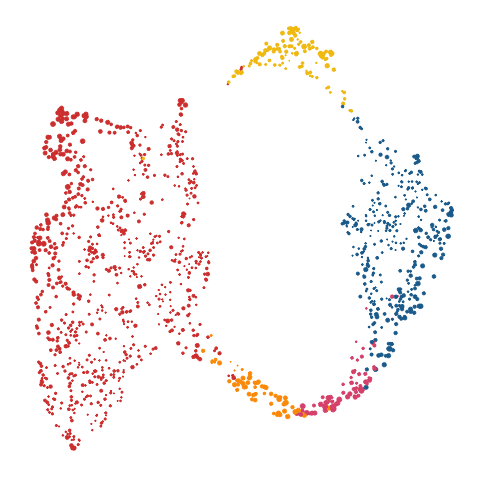

In [68]:
%%R -i seurat_obj -o seurat_obj

# get the hub gene UMAP table from the seurat object

umap_df <- list()

for (cell_type in names(seurat_obj)){

  print(paste0('Store Module UMAP in hdWGCNA Experiment for ', toupper(cell_type)))

  umap_df[[cell_type]] <- GetModuleUMAP(seurat_obj[[cell_type]])

}

# plot sample for Excitatory cells with ggplot
ggplot(umap_df[[celltypes[1]]], aes(x=UMAP1, y=UMAP2)) +
  geom_point(
   color=umap_df[[celltypes[1]]]$color, # color each point by WGCNA module
   size=umap_df[[celltypes[1]]]$kME*2 # size of each point based on intramodular connectivity
  ) +
  umap_theme()

In [69]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

In this plot, each point represents a single gene. The size of each dot is scaled by the gene’s kME for it’s assigned module. ggplot2 is sufficient to visualize the genes in the module UMAP, but here we are not visualizing the underlying network. We can use the function ModuleUMAPPlot to plot the genes and their co-expression relationships.

In [70]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/HubGeneUMAP/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('UMAP Plot of Connectivities in hdWGCNA Experiment for ', toupper(cell_type)))

  # hubgene network

  pdf(paste0(fig_dir, cell_type, '_hubgene_umap_igraph.pdf'), width=10, height=10)

  ModuleUMAPPlot(
    seurat_obj[[cell_type]],
    edge.alpha = 0.25,
    sample_edges=TRUE,
    keep_grey_edges=FALSE,
    edge_prop=0.1,  # proportion of edges to sample (10% here) # taking the top 10% strongest edges in each module 
    #label_genes = label_genes,
    label_hubs=2 # how many hub genes to plot per module?
  )
  dev.off()
}

[1] "UMAP Plot of Connectivities in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "hub labels"
 [1] "SLC26A3"  "SNAP25"   "NLGN1"    "IL1RAPL1" "MAP1B"    "TMSB4X"  
 [7] "DLGAP1"   "SYT1"     "PHACTR1"  "CELF2"   
NULL
 [1] "SLC26A3"  "SNAP25"   "NLGN1"    "IL1RAPL1" "MAP1B"    "TMSB4X"  
 [7] "DLGAP1"   "SYT1"     "PHACTR1"  "CELF2"   
[1] 35900     3
[1] 719   4
[1] "making net"
# A tibble: 6 × 5
# Groups:   color [5]
  Var1    Var2     value color   color_alpha
  <fct>   <fct>    <dbl> <chr>   <chr>      
1 CDH13   DMD    0       #fe9b00 #FE9B0000  
2 NDRG2   MAP1B  0       #f4c40f #F4C40F00  
3 ASCC1   CACNB2 0       #1f6e9c #1F6E9C00  
4 SFPQ    SNAP25 0       #d8443c #D8443C00  
5 NSMCE2  SYT1   0       #de597c #DE597C00  
6 SLC24A2 DLGAP1 0.00257 #de597c #DE597C01  
        gene_name module   color  kME_grey kME_EXC-M1 kME_EXC-M2 kME_EXC-M3
KHSRP       KHSRP EXC-M1 #

In [71]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

Next, our hypothesis is that the hub genes are the differentially expressed genes that are in the overlapping pathways.

### **Visualizing Hub Genes: Overlapping Pathways and DEGs**

The hub genes, which are also differentially expressed genes (DEGs), can be visualized in the pathways where they overlap. You can find the results of this analysis saved at `f'../results/{test_name}/{study}_{deg_method}_{cell_type}_DEGs_in_overlapping_pathways.csv.csv` from the previous analysis.

Save to pathway names to R

In [72]:
%%R -i test_names -i deg_method -i seurat_obj -o seurat_obj


conflicts_prefer(base::intersect)

fig_dir = paste0("../results/hdWGCNA/HubGeneUMAP/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

# label the DEGs in the overlapping pathways

for (test in c('ad_vs_no')){

  print(toupper(test))
  for (cell_type in names(seurat_obj)){

    print(paste0('UMAP Plot of Hub-DEG Connectivities in hdWGCNA Experiment for ', toupper(cell_type)))

    # hubgene network

    overlap_degs <- read.csv(paste0('../results/', test, '/', save_prefix, '_', deg_method, '_',
                           cell_type, "_DEGs_in_overlapping_pathways.csv"), header=TRUE)

    hub_genes <- GetHubGenes(seurat_obj[[cell_type]], 25)
    label_genes <- intersect(hub_genes$gene_name, unique(overlap_degs$x))
    
    if (length(label_genes) == 0) {
      print(paste0('No genes to label for ', toupper(cell_type)))
      print('setting label_genes to NULL')
      label_genes <- NULL
    } else {
      label_genes <- label_genes
    }


    pdf(paste0(fig_dir, test, "_", cell_type, '_overlap_hubDEGs_umap_igraph.pdf'), width=10, height=10)
    ModuleUMAPPlot(
      seurat_obj[[cell_type]],
      edge.alpha=0.25,
      sample_edges=TRUE,
      keep_grey_edges=FALSE,
      edge_prop=0.1,  # proportion of edges to sample (10% here) # taking the top 10% strongest edges in each module 
      label_genes = label_genes,
      label_hubs=0 # how many hub genes to plot per module?
    )
    dev.off()
  }

}



[conflicted] Will prefer base::intersect over any other package.
[1] "AD_VS_NO"
[1] "UMAP Plot of Hub-DEG Connectivities in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "hub labels"
character(0)
 [1] "FAIM2"   "MAPK1"   "SLC17A7" "CLSTN1"  "THY1"    "ARPP19"  "YWHAG"  
 [8] "PRNP"    "DNM1"    "GPM6A"   "CHN1"    "SNAP25"  "N4BP2L2" "LRRC4C" 
[15] "NLGN1"   "NDUFA4"  "RPL21"   "RPL10"   "RPL7"    "RPL6"    "RPS14"  
[22] "RPL41"   "PRKCB"   "CACNA1A" "CACNA1C"
 [1] "FAIM2"   "MAPK1"   "SLC17A7" "CLSTN1"  "THY1"    "ARPP19"  "YWHAG"  
 [8] "PRNP"    "DNM1"    "GPM6A"   "CHN1"    "SNAP25"  "N4BP2L2" "LRRC4C" 
[15] "NLGN1"   "NDUFA4"  "RPL21"   "RPL10"   "RPL7"    "RPL6"    "RPS14"  
[22] "RPL41"   "PRKCB"   "CACNA1A" "CACNA1C"
[1] 35900     3
[1] 719   4
[1] "making net"
# A tibble: 6 × 5
# Groups:   color [5]
  Var1   Var2      value color   color_alpha
  <fct>  <fct>     <d

In [73]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

# **Save Seurat Object**

In [ ]:
%%R -i seurat_obj -o seurat_obj

dat_dir = paste0("../results/hdWGCNA/SeuratObject/", save_prefix, '/')

if (!dir.exists(dat_dir)) {
  dir.create(dat_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){
    
    print(paste0('Saving hdWGCNA object in hdWGCNA Experiment for ', toupper(cell_type)))

    saveRDS(seurat_obj[[cell_type]], file=paste0(dat_dir, cell_type, '_hdWGCNA_object.rds'))

}